# Air Pollution and the COVID-19 Pandemic

The COVID-19 pandemic has caused an unprecedented disruption in every aspect of human activity, on a global scale. Billions of people have been affected by the disease in numerous ways, and felt its impact in their daily lives. Fortunately and perhaps unexpectedly, the pandemic had a few beneficial effects as well. The various measures implemented by governments all over the world, like travel restrictions, border closures and lockdowns, have led to the decrease of air pollution in many countries. Air pollution is itself a major health issue, causing millions of deaths on a yearly basis. In this notebook we are going to explore the decrease of air pollution during the COVID-19 pandemic in various cities, using satellite data.

## Air Pollution decrease in Italy

In [10]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors
import xarray as xr
import numpy as np
import cartopy
import matplotlib.gridspec as gridspec
from glob import iglob
from os.path import join
from functools import reduce
import pandas as pd
import geopandas as gpd
from cartopy.io import shapereader
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import imageio
import warnings

files_L2 = sorted(list(iglob(join('data\L2', '*'), recursive=True)))
files_L3 = sorted(list(iglob(join('data\L3', '*'), recursive=True)))

attributes = {
        i.split('\\')[-1]: {
            'time_coverage_start': xr.open_dataset(i).attrs['time_coverage_start'],
            'time_coverage_end': xr.open_dataset(i).attrs['time_coverage_end'],
        } for i in files_L2
    }

def preprocess(ds):
    ds['time'] = pd.to_datetime(np.array([attributes[ds.attrs['source_product']]['time_coverage_start']])).values
    return ds

L3_MCH_19_20 = xr.open_mfdataset(files_L3, combine='nested', concat_dim='time', preprocess=preprocess, chunks={'time': 100})

L3_MCH_19 = L3_MCH_19_20.sel(time=slice('2019-03-01', '2019-03-31'))
L3_MCH_19 = L3_MCH_19.resample(time='1D').mean(dim='time', skipna=None)

L3_MCH_20 = L3_MCH_19_20.sel(time=slice('2020-03-01', '2020-03-31'))
L3_MCH_20 = L3_MCH_20.resample(time='1D').mean(dim='time', skipna=None)

L3_MCH_19_mean = L3_MCH_19.mean(dim='time')
no2_MCH_19_mean = L3_MCH_19_mean['tropospheric_NO2_column_number_density']

L3_MCH_20_mean = L3_MCH_20.mean(dim='time')
no2_MCH_20_mean = L3_MCH_20_mean['tropospheric_NO2_column_number_density']

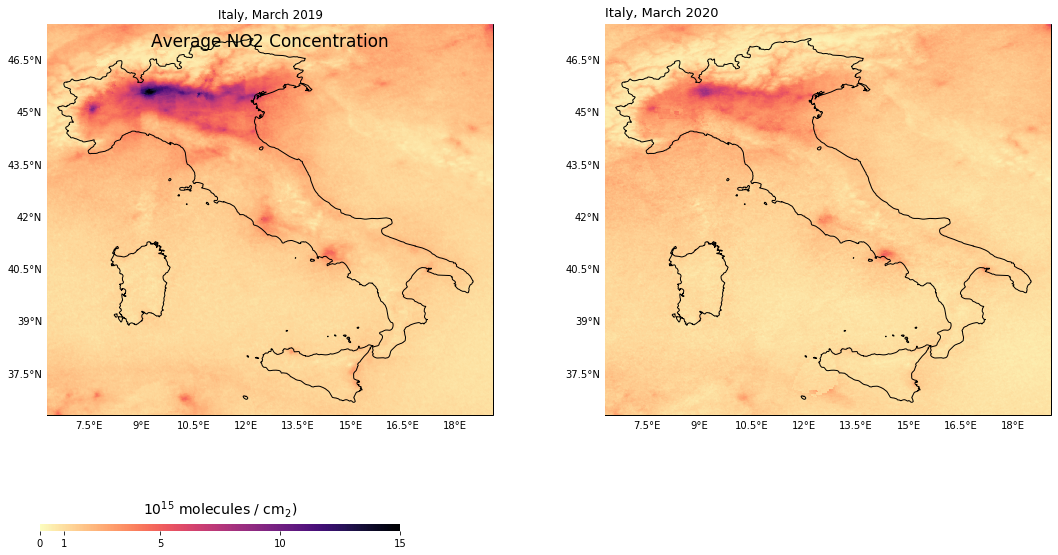

In [161]:
warnings.filterwarnings('ignore')

# Creating the main figure and the two subplots
fig = plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0)


ax1 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax1.set_extent([6.3, 19.1, 36.3, 47.5])

ax2 = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax2.set_extent([6.3, 19.1, 36.3, 47.5])

# Adding the map of Italy
shp_country = shapereader.natural_earth(resolution='10m', 
                                    category='cultural', 
                                    name='admin_0_countries')
df = gpd.read_file(shp_country)
poly = df.loc[df['ADMIN'] == 'Italy']['geometry']

ax1.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', zorder=3)
ax2.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', zorder=3)

# Add NO2 data
im1 = no2_MCH_19_mean.plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), cmap='magma_r', vmin=0, vmax=15, x='longitude', y='latitude', zorder=3)
im1.colorbar.remove()

im2 = no2_MCH_20_mean.plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), cmap='magma_r', vmin=0, vmax=15, x='longitude', y='latitude', zorder=3)
im2.colorbar.remove()


# set plot frame 
gl1 = ax1.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle=':')
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER

gl2 = ax2.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle=':')
gl2.xlabels_top = False
gl2.ylabels_right = False
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER

# set colorbar properties
cbar_ax = fig.add_axes([0.12, 0.07, 0.25, 0.01])
cbar = plt.colorbar(im1, cax=cbar_ax, orientation='horizontal', ticks=[0,1,5,10,15])
cbar.set_label(r"$10^{15}$ molecules / cm$_2$)", labelpad=-50, fontsize=14)
cbar.outline.set_visible(False)
cbar.ax.set_yticklabels(['0','1', '5', '10', '15'])

# Add text
fig.text(0, 1.07, 'Average NO2 concentration', fontsize = 17, transform=ax1.transAxes)
#fig.text(0.61, -0.21, "Data: ESA Sentinel-5p / TROPOMI", fontsize=12, color='gray', multialignment='right',transform=ax1.transAxes)
ax1.text(0, 1.02, 'Italy, March 2019', fontsize = 13, transform=ax1.transAxes)
ax2.text(0, 1.02, 'Italy, March 2020', fontsize = 13, transform=ax2.transAxes)

plt.show()